# RONAALP 

Testing on high-fidelity data of hypersonic reacting boundary layer 

In [1]:
import os
import re
import sys
import math
import glob as gb
import numpy as np
import pickle 
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from RONAALP import Ronaalp

In [2]:
# Data can be requested to the authors upon reasonable request. 

path = 'data/'


X = np.loadtxt(path+"samples_in.csv",  dtype=np.float64, delimiter=",")
Z = np.loadtxt(path+"samples_out.csv", dtype=np.float64, delimiter=",")

# Split between train and text 

n_samples = X.shape[0]

labels = range(n_samples)

X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2, random_state=42)

Z_train = Z[labels_train,:]
Z_test  = Z[labels_test,:]


## Visualization 

In [3]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_scaled = scaler.transform(X_train)

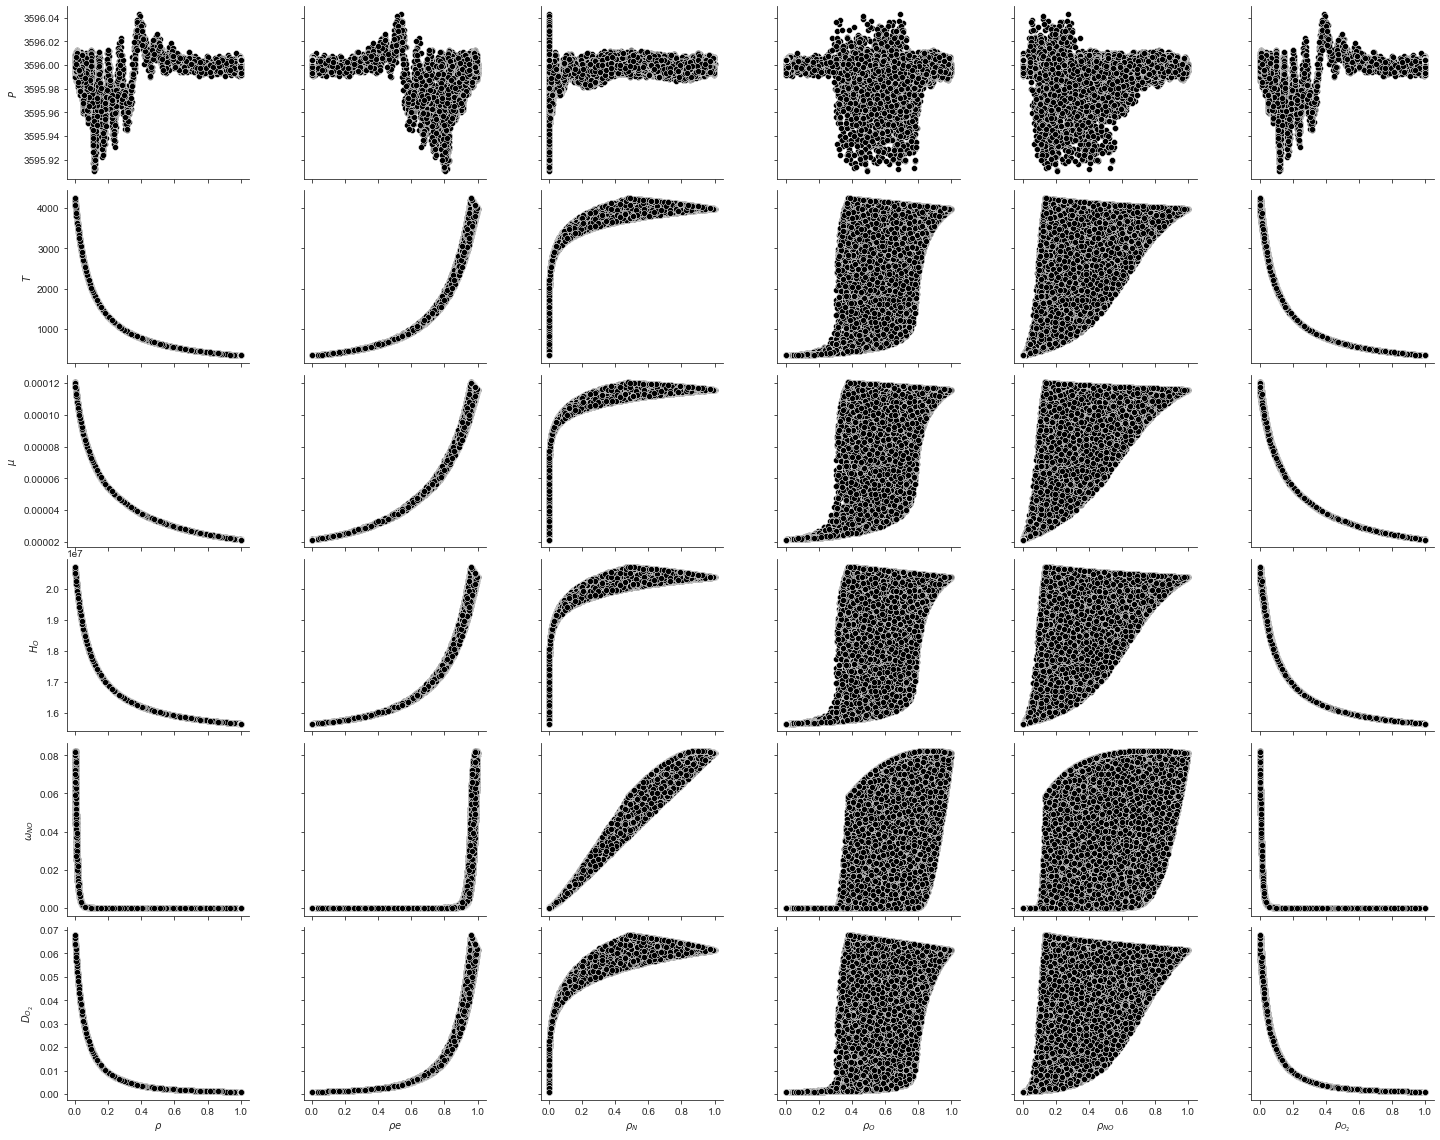

In [4]:
# Visualize input/ouput relations

nameX = [r'$\rho$', r'$\rho e$', r'$\rho_{N}$', r'$\rho_{O}$', r'$\rho_{NO}$', r'$\rho_{O_2}$']
nameY = [r'$P$', r'$T$',r'$\mu$', r'$\kappa$', r'$H_{N}$', r'$H_{O}$',r'$H_{NO}$',r'$H_{O_2}$',r'$H_{N_2}$',r'$\omega_{N}$', r'$\omega_{O}$', r'$\omega_{NO}$',r'$\omega_{O_2}$',r'$D_{N}$', r'$D_{O}$', r'$D_{NO}$', r'$D_{O_2}$', r'$D_{N_2}$']

rand_index = np.random.choice(X_scaled.shape[0], 30000, replace=False)  

if True:
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    cols  = nameX + nameY
    data  = np.concatenate((X_scaled[rand_index,:],Z_train[rand_index,:]), axis = -1)
    df    = pd.DataFrame(data=data, columns=cols)

    x_vars = nameX
    y_vars = [nameY[i] for i in [0,1,2,5,11,16]]

    g = sns.PairGrid(df, x_vars=x_vars, y_vars=y_vars, palette = 'black' , height=3.3, aspect=1.3)
    g.map(sns.scatterplot, color='k', rasterized=True)

    fig = g.fig 
    fig.subplots_adjust(top=0.93, wspace=0.3)
    fig.set_figwidth(20)
    fig.set_figheight(17)

In [5]:
n_features = X_train.shape[-1]

model = PCA(n_components=n_features)
model.fit_transform(X_scaled)

comp = np.arange(1,n_features+1, step=1)
var  = np.cumsum(model.explained_variance_ratio_)

# of components to keep :  2
[0.88581949 0.96498245 0.99831002 0.99995122 1.         1.        ]


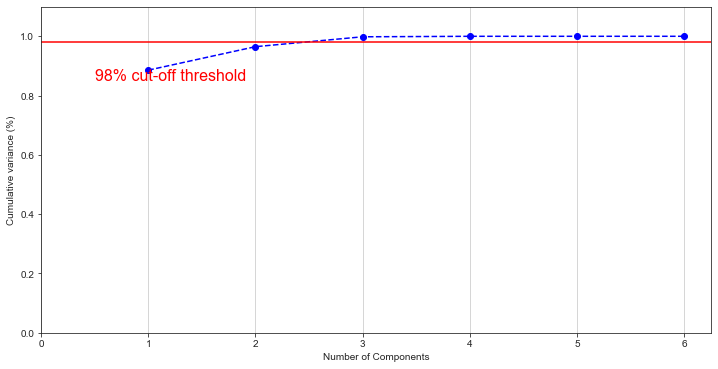

In [6]:
plt.rcParams["figure.figsize"] = (12,6)
fig, axp = plt.subplots()

plt.ylim(0.0,1.1)
plt.plot(comp, var, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_features+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')

plt.axhline(y=0.98, color='r', linestyle='-')
plt.text(0.5, 0.85, '98% cut-off threshold', color = 'red', fontsize=16)

axp.grid(axis='x')

n_components = np.argmax(var>0.95)+1

print("# of components to keep : ", n_components)
print(var)

# TRAINING

In [7]:
# Initialization of the RONALP class

model =  Ronaalp(d=2, n_rbf=200, rbf_degree=3, rbf_smoothing=1e-3, n_epochs=100, method='Spline', architecture=[12,6], clustering=False)

In [8]:
# Training 

model.train(X_train,Z_train,X_test,Z_test) 

1. Setting up scalers ...
... Done !
2. Training encoder, latent space dimenion  d = 2 ...
Epoch 1/100
575/575 [==============================] - 1s 1ms/step - loss: 0.0377 - accuracy: 0.4565 - val_loss: 0.0051 - val_accuracy: 0.5533
Epoch 2/100
575/575 [==============================] - 1s 1ms/step - loss: 0.0029 - accuracy: 0.6467 - val_loss: 0.0018 - val_accuracy: 0.6510
Epoch 3/100
575/575 [==============================] - 1s 1ms/step - loss: 0.0015 - accuracy: 0.6158 - val_loss: 0.0013 - val_accuracy: 0.5896
Epoch 4/100
575/575 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.5668 - val_loss: 0.0011 - val_accuracy: 0.5511
Epoch 5/100
575/575 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.5559 - val_loss: 9.0975e-04 - val_accuracy: 0.5665
Epoch 6/100
575/575 [==============================] - 1s 1ms/step - loss: 8.3086e-04 - accuracy: 0.5794 - val_loss: 7.5019e-04 - val_accuracy: 0.5928
Epoch 7/100
575/575 [==================

/Users/clement/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


P size (200, 10)
... Done !


# Testing

In [9]:
# Evaluation

Z_test_pred, extrp = model.evaluate(X_test)

In [10]:
# Comparing values 

print(Z_test_pred[0])
print(Z_test[0])

[ 3.59600369e+03  3.84774809e+03  1.12727734e-04  2.12684700e-01
  3.90288790e+07  2.02062983e+07  7.20730715e+06  4.07087456e+06
  4.39727240e+06 -1.17556196e-04  1.41153028e-01  4.46045189e-02
 -1.64936377e-01  7.41019931e-02  8.10614216e-02  4.81107894e-02
  5.77024588e-02  5.92158319e-02]
[ 3.59600841e+03  3.84783406e+03  1.12729243e-04  2.12687671e-01
  3.90290118e+07  2.02064125e+07  7.20741300e+06  4.07098176e+06
  4.39738542e+06 -1.14613547e-04  1.41183045e-01  4.46121700e-02
 -1.64970474e-01  7.41046451e-02  8.10647346e-02  4.81124968e-02
  5.77044537e-02  5.92177287e-02]


# Saving model

In [11]:
with open('RONALP_model', 'wb') as file:
            pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://51caf382-228d-4490-8590-644dfce5f14d/assets


# Loading new data with extrapolation

In [12]:
X_new = np.loadtxt(path+"samples_new_in.csv",  dtype=np.float64, delimiter=",")
Z_new = np.loadtxt(path+"samples_new_out.csv", dtype=np.float64, delimiter=",")

In [13]:
# Evaluation

Z_new_pred, extrp = model.evaluate(X_new)

In [14]:
# Find extrapolated points

index = np.where(extrp==1)[0]
print(index.shape)

X_new_exp      = X_new[index]
Z_new_pred_exp = Z_new_pred[index]
Z_new_exp      = Z_new[index]

(106565,)


In [15]:
# Compare outputs for a data point known in extrapolation 

print(Z_new_pred_exp[0])
print(Z_new_exp[0])

[ 3.59606556e+03  4.03357434e+03  1.12860933e-04  2.11401137e-01
  3.93961517e+07  2.04829183e+07  7.44924185e+06  4.35838632e+06
  4.66548839e+06  1.18272592e-02  1.07768801e+00  2.33670591e-01
 -1.20228231e+00  9.05544073e-02  1.02451916e-01  5.87961357e-02
  6.96634891e-02  7.08067613e-02]
[ 3.59597317e+03  5.30923552e+03  1.37825711e-04  2.64177934e-01
  4.13592904e+07  2.21632464e+07  8.99894860e+06  5.86674664e+06
  6.30045916e+06  2.65885017e-02  2.02184966e+00  3.51694757e-01
 -2.20937503e+00  1.19717691e-01  1.41823682e-01  7.77825713e-02
  9.22849170e-02  9.53336669e-02]


# Updating model

In [16]:
model.update(X_new_exp, Z_new_exp)

In [17]:
Z_new_updt,_  = model.evaluate(X_new)

Z_new_updt_exp = Z_new_updt[index]

In [18]:
# Compare L2 norm before and after update of the model 

err = np.linalg.norm(Z_new - Z_new_pred)
err_updt = np.linalg.norm(Z_new - Z_new_updt)

print('Error norm before update, err = '+str(err))
print('Error norm after  update, err = '+str(err_updt))

Error norm before update, err = 1300315219.8520272
Error norm after  update, err = 75226098.79375754


In [19]:
# Compare outputs for a data point known in extrapolation 

print(Z_new_updt_exp[0])
print(Z_new_exp[0])

[ 3.59597287e+03  5.31141807e+03  1.37870009e-04  2.64274605e-01
  4.13626701e+07  2.21661204e+07  9.00158991e+06  5.86926507e+06
  6.30322810e+06  2.66247827e-02  2.02394761e+00  3.52196092e-01
 -2.21174030e+00  1.19761370e-01  1.41880385e-01  7.78110498e-02
  9.23191573e-02  9.53710936e-02]
[ 3.59597317e+03  5.30923552e+03  1.37825711e-04  2.64177934e-01
  4.13592904e+07  2.21632464e+07  8.99894860e+06  5.86674664e+06
  6.30045916e+06  2.65885017e-02  2.02184966e+00  3.51694757e-01
 -2.20937503e+00  1.19717691e-01  1.41823682e-01  7.77825713e-02
  9.22849170e-02  9.53336669e-02]
